# Build a contextual text and image search engine for product recommendations using Amazon Bedrock (Titan Multimodal Embedding) and Amazon OpenSearch Serverless

The solution presented provides an implementation for building a Amazon Titan Multilodal Embedding Model powered search engine prototype to retrieve and recommend products based on text or image queries. This is a step-by-step guide on how to use [Amazon Bedrock Titan models](https://aws.amazon.com/bedrock/titan) to encode images and text into embeddings, ingest embeddings into [Amazon OpenSearch Service](https://aws.amazon.com/opensearch-service/) index, and query the index using OpenSearch Service [k-nearest neighbors (KNN) functionality](https://docs.aws.amazon.com/opensearch-service/latest/developerguide/knn.html).


It's recommended to execute the notebook in SageMaker Studio Notebooks `Python 3.0(Data Science)` Kernel with `ml.t3.medium` instance.

This notebook has been borrrowed from -- Bedrock samples link here -- [MultiModal Embeddings](https://github.com/aws-samples/amazon-bedrock-samples/tree/main/multimodal/titan-multimodal-embeddings)

Install dependencies

In [2]:
!pip install opensearch-py
!pip install requests-aws4auth
!pip install -U boto3
!pip install -U botocore
!pip install -U awscli
!pip install s3fs
!pip install sns
!pip install seaborn
!pip install sagemaker

  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
Using cached dill-0.3.8-py3-none-any.whl (116 kB)
  Attempting uninstall: dill
    Found existing installation: dill 0.3.1.1
    Uninstalling dill-0.3.1.1:
      Successfully uninstalled dill-0.3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.52.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
datasets 2.19.2 requires pyarrow>=12.0.0, but you have pyarrow 11.0.0 which is incompatible.


In [3]:
%pip install -U --no-cache-dir boto3
%pip install -U --no-cache-dir  \
    "langchain>=0.1.11" \
    sqlalchemy -U \
    "faiss-cpu>=1.7,<2" \
    "pypdf>=3.8,<4" \
    pinecone-client==2.2.4 \
    apache-beam==2.52. \
    tiktoken==0.5.2 \
    "ipywidgets>=7,<8" \
    matplotlib==3.8.2 \
    anthropic==0.9.0
%pip install -U --no-cache-dir transformers

Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78541 sha256=6c03097e6967cc00767dd2704dadce8ebdd14a61d4a2227f0b696d110dd7cfdd
  Stored in directory: /tmp/pip-ephem-wheel-cache-6pdf_kk9/wheels/ea/e2/86/64980d90e297e7bf2ce588c2b96e818f5399c515c4bb8a7e4f
Successfully built dill
  Attempting uninstall: dill
    Found existing installation: dill 0.3.8
    Uninstalling dill-0.3.8:
      Successfully uninstalled dill-0.3.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.19.2 requires pyarrow>=12.0.0, but you have pyarrow 11.0.0 which is incompatible.
multiprocess 0.70.16 requires dill>=0.3.8, but you have dill 0.3.1.1 which is incompatible.
pathos 0.3

In [4]:
!pip install sqlalchemy --upgrade

In [5]:
# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

## 1. Setup

Install some python packages we are going to use in the POC. For the sake of abstraction, we have defined all important function used in this notebook in utils.py

In [6]:
import boto3
import pandas as pd
import os
import re
import boto3
import json
import time
import base64
import logging
import numpy as np
import seaborn as sns
from PIL import Image
from io import BytesIO


from tqdm import tqdm
from urllib.parse import urlparse
from multiprocessing.pool import ThreadPool
from sagemaker.s3 import S3Downloader as s3down

# import sagemaker
# from utils import *
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth, helpers
from PIL import Image
import matplotlib.pyplot as plt

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [7]:
import boto3
import os
from IPython.display import Markdown, display, Pretty

# getting boto3 clients for required AWS services
sts_client = boto3.client('sts')
s3_client = boto3.client('s3')
#aoss_client = boto3.client('opensearchserverless')



region = os.environ.get("AWS_REGION")
boto3_bedrock = boto3.client(
    service_name='bedrock-runtime',
    region_name=region,
)

## 2. Load publically available dataset

For this notebook, you are using the Amazon Berkeley Objects Dataset. The dataset is a collection of 147,702 product listings with multilingual metadata and 398,212 unique catalog images. 8,222 listings come with turntable photography. You will only make use of the item images and item name in US English (which is we consider as the product’s short description). For demo purposes you are going to use about 1,600 products for this practice. 

In [8]:
# Bedrock models
# Select Amazon titan-embed-image-v1 as Embedding model for multimodal indexing
multimodal_embed_model = f'amazon.titan-embed-image-v1'


""" 
Function to plot heatmap from embeddings
"""

def plot_similarity_heatmap(embeddings_a, embeddings_b):
    inner_product = np.inner(embeddings_a, embeddings_b)
    sns.set(font_scale=1.1)
    graph = sns.heatmap(
        inner_product,
        vmin=np.min(inner_product),
        vmax=1,
        cmap="OrRd",
    )

""" 
Function to fetch the image based on image id from dataset
"""
def get_image_from_item_id( item_id = "0", dataset = None, return_image=True):
 
    item_idx = dataset.query(f"item_id == {item_id}").index[0]
    img_path = dataset.iloc[item_idx].image_path
    
    if return_image:
        img = Image.open(img_path)
        return img, dataset.iloc[item_idx].item_desc
    else:
        return img_path, dataset.iloc[item_idx].item_desc
    print(item_idx,img_path)


""" 
Function to fetch the image based on image id from S3 bucket
"""
    
def get_image_from_item_id_s3(item_id = "B0896LJNLH", dataset = None, image_path = None,  return_image=True):

    item_idx = dataset.query(f"item_id == '{item_id}'").index[0]
    img_loc =  dataset.iloc[item_idx].img_full_path
    
    if img_loc.startswith('s3'):
        # download and store images locally 
        local_data_root = f'./data/images'
        local_file_name = img_loc.split('/')[-1]
 
        s3down.download(img_loc, local_data_root)
 
    local_image_path = f"{local_data_root}/{local_file_name}"
    
    if return_image:
        img = Image.open(local_image_path)
        return img, dataset.iloc[item_idx].item_name_in_en_us
    else:
        return local_image_path, dataset.iloc[item_idx].item_name_in_en_us

""" 
Function to display the images.
"""
def display_images(images: [Image], columns=2, width=20, height=8, max_images=15, label_wrap_length=50, label_font_size=8):
 
    if not images:
        print("No images to display.")
        return 
 
    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images=images[0:max_images]
 
    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):
 
        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.imshow(image)
 
        if hasattr(image, 'name_and_score'):
            plt.title(image.name_and_score, fontsize=label_font_size); 
            




### 2.1 Data overview and preparation

Load the metadata

You can use pandas to load metadata, then select products which have titles in US English from the data frame. You will use a column called main_image_id to merge item name with item image later.

In [9]:
meta = pd.read_json("s3://amazon-berkeley-objects/listings/metadata/listings_0.json.gz", lines=True)
def func_(x):
    us_texts = [item["value"] for item in x if item["language_tag"] == "en_US"]
    return us_texts[0] if us_texts else None

meta = meta.assign(item_name_in_en_us=meta.item_name.apply(func_))
meta = meta[~meta.item_name_in_en_us.isna()][["item_id", "item_name_in_en_us", "main_image_id"]]
print(f"#products with US English title: {len(meta)}")
meta.head()

/opt/conda/lib/python3.10/site-packages/fsspec/registry.py:275: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


#products with US English title: 1655


,item_id,item_name_in_en_us,main_image_id
7,B0896LJNLH,AmazonBasics Serene 16-Piece Old Fashioned and...,61izEZdhlaL
18,B07HCR1LSQ,[Find] Amazon Collection Platinum Plated Sterl...,61kDp2x8tPL
22,B075DQBBJZ,Arizona Desert Sand Horizon Photo with Wood Ha...,91IjyKZ76qL
38,B07S74D9T7,AmazonBasics Adjustable Speaker Stand - 3.8 to...,71x4c-BafpL
39,B01N27SMXC,Amazon Brand - The Fix Women's Foley Tassel Sl...,71-eMu0gN+L


You should be able to see over 1600 products in the data frame.
Next, you can link the item names with item images. `images/metadata/images.csv.gz` contains Image metadata. This file is a gzip-compressed comma-separated value (CSV) file with the following columns: `image_id`, `height`, `width`, and `path`. You can read the meta data file and then merge it with item metadata.

In [10]:
image_meta = pd.read_csv("s3://amazon-berkeley-objects/images/metadata/images.csv.gz")
dataset = meta.merge(image_meta, left_on="main_image_id", right_on="image_id")

In [11]:
# Create a new column in dataset with FULL PATH of the image
dataset = dataset.assign(img_full_path=f's3://amazon-berkeley-objects/images/small/' + dataset.path.astype(str))
dataset

,item_id,item_name_in_en_us,main_image_id,image_id,height,width,path,img_full_path
0,B0896LJNLH,AmazonBasics Serene 16-Piece Old Fashioned and...,61izEZdhlaL,61izEZdhlaL,1197,894,07/075e5d67.jpg,s3://amazon-berkeley-objects/images/small/07/0...
1,B07HCR1LSQ,[Find] Amazon Collection Platinum Plated Sterl...,61kDp2x8tPL,61kDp2x8tPL,1000,1000,c9/c923418f.jpg,s3://amazon-berkeley-objects/images/small/c9/c...
2,B075DQBBJZ,Arizona Desert Sand Horizon Photo with Wood Ha...,91IjyKZ76qL,91IjyKZ76qL,2560,2560,c6/c6889ed4.jpg,s3://amazon-berkeley-objects/images/small/c6/c...
3,B07S74D9T7,AmazonBasics Adjustable Speaker Stand - 3.8 to...,71x4c-BafpL,71x4c-BafpL,2560,2560,2b/2b90e918.jpg,s3://amazon-berkeley-objects/images/small/2b/2...
4,B01N27SMXC,Amazon Brand - The Fix Women's Foley Tassel Sl...,71-eMu0gN+L,71-eMu0gN+L,704,1770,2c/2c0416de.jpg,s3://amazon-berkeley-objects/images/small/2c/2...
...,...,...,...,...,...,...,...,...
1644,B07JCDQWM6,Amazon Brand – Rivet Thomas Modern Leather Sof...,71e51Rb1h4L,71e51Rb1h4L,2560,2560,c4/c4c46850.jpg,s3://amazon-berkeley-objects/images/small/c4/c...
1645,B07B1LZQWL,"Salmon Cake with Confetti Grains, 12.17 oz",91qFxcWDtjL,91qFxcWDtjL,1982,2560,01/0111c309.jpg,s3://amazon-berkeley-objects/images/small/01/0...
1646,B073P17SZZ,Amazon Brand – Rivet Blue Ocean Waves Print Wa...,91NCaDVKPEL,91NCaDVKPEL,1719,2560,85/85d5420a.jpg,s3://amazon-berkeley-objects/images/small/85/8...
1647,B07JQX8S2X,Amazon Basics Tufted Outdoor Square Seat Patio...,91XM523rZgL,91XM523rZgL,2560,2560,45/45e8e821.jpg,s3://amazon-berkeley-objects/images/small/45/4...


You can have a look at one sample image from the dataset by running the following code

AmazonBasics Serene 16-Piece Old Fashioned and Coolers Glass Drinkware Set


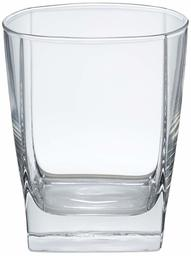

In [12]:
image, item_name = get_image_from_item_id_s3(item_id = "B0896LJNLH", dataset = dataset, image_path = f's3://amazon-berkeley-objects/images/small/' )
print(item_name)
image

## 3. Generate embedding from item images

Amazon Titan Multimodal Embeddings G1 Generation 1 (G1) is able to project both images and text into the same latent space, so we only need to encode item images or texts into embedding space. In this practice, you can use [batch inference](https://docs.aws.amazon.com/bedrock/latest/userguide/batch-inference.html) to encode item images. Before creating the job, you need to copy item images from Amazon Berkeley Objects Dataset public S3 bucket to your own S3 Bucket. The operation needs take less than 10 mins.

But for this notebook, we'll use real-time API than batch inference. 

In [13]:

batch_size=10
dataset = dataset.iloc[:batch_size]
dataset

,item_id,item_name_in_en_us,main_image_id,image_id,height,width,path,img_full_path
0,B0896LJNLH,AmazonBasics Serene 16-Piece Old Fashioned and...,61izEZdhlaL,61izEZdhlaL,1197,894,07/075e5d67.jpg,s3://amazon-berkeley-objects/images/small/07/0...
1,B07HCR1LSQ,[Find] Amazon Collection Platinum Plated Sterl...,61kDp2x8tPL,61kDp2x8tPL,1000,1000,c9/c923418f.jpg,s3://amazon-berkeley-objects/images/small/c9/c...
2,B075DQBBJZ,Arizona Desert Sand Horizon Photo with Wood Ha...,91IjyKZ76qL,91IjyKZ76qL,2560,2560,c6/c6889ed4.jpg,s3://amazon-berkeley-objects/images/small/c6/c...
3,B07S74D9T7,AmazonBasics Adjustable Speaker Stand - 3.8 to...,71x4c-BafpL,71x4c-BafpL,2560,2560,2b/2b90e918.jpg,s3://amazon-berkeley-objects/images/small/2b/2...
4,B01N27SMXC,Amazon Brand - The Fix Women's Foley Tassel Sl...,71-eMu0gN+L,71-eMu0gN+L,704,1770,2c/2c0416de.jpg,s3://amazon-berkeley-objects/images/small/2c/2...
5,B0896KVCJY,AmazonBasics Eastlake Coolers Glass Drinkware ...,610jXVKNJpL,610jXVKNJpL,1630,863,ea/ea0c6da6.jpg,s3://amazon-berkeley-objects/images/small/ea/e...
6,B07QC4DZ2L,"365 EVERYDAY VALUE Organic Light Cream, 1 PT",81oNfRT6ebL,81oNfRT6ebL,2560,1431,e7/e7983ec5.jpg,s3://amazon-berkeley-objects/images/small/e7/e...
7,B07FW2NYGJ,"365 EVERYDAY VALUE Chai Spice Cashews, 10 OZ",91T4zCd6GhL,91T4zCd6GhL,2560,2102,dc/dcf40fb6.jpg,s3://amazon-berkeley-objects/images/small/dc/d...
8,B083V9N454,"Belei Blemish Control Spot Treatment, 5.5% Ben...",51fDZFHuHjL,51fDZFHuHjL,1001,1001,72/729ff131.jpg,s3://amazon-berkeley-objects/images/small/72/7...
9,B07N6V9Z41,AmazonBasics Non-Slip Bathroom Bath Rug Mat wi...,810iH82SMKL,810iH82SMKL,2560,2560,f0/f0f82cfb.jpg,s3://amazon-berkeley-objects/images/small/f0/f...


In [14]:
# for i in enumerate(zip(dataset['img_full_path'], dataset['item_name_in_en_us'])):
#     print(i[0], i[1])
for img_details in enumerate(zip(dataset['img_full_path'], dataset['item_name_in_en_us'])):
    print(img_details[0], img_details[1])

0 ('s3://amazon-berkeley-objects/images/small/07/075e5d67.jpg', 'AmazonBasics Serene 16-Piece Old Fashioned and Coolers Glass Drinkware Set')
1 ('s3://amazon-berkeley-objects/images/small/c9/c923418f.jpg', '[Find] Amazon Collection Platinum Plated Sterling Silver Clear Princess kattokyu-bikkuzirukoniasutaddopiasu Binaural Headset for Stud Earrings jee00087\xa0_ 120cl00qd00\xa0')
2 ('s3://amazon-berkeley-objects/images/small/c6/c6889ed4.jpg', 'Arizona Desert Sand Horizon Photo with Wood Hanger')
3 ('s3://amazon-berkeley-objects/images/small/2b/2b90e918.jpg', 'AmazonBasics Adjustable Speaker Stand - 3.8 to 6-Foot, Steel')
4 ('s3://amazon-berkeley-objects/images/small/2c/2c0416de.jpg', "Amazon Brand - The Fix Women's Foley Tassel Slide Sandal, Taupe, 6.5 B US")
5 ('s3://amazon-berkeley-objects/images/small/ea/ea0c6da6.jpg', 'AmazonBasics Eastlake Coolers Glass Drinkware Set, 15-Ounce, Set of 6')
6 ('s3://amazon-berkeley-objects/images/small/e7/e7983ec5.jpg', '365 EVERYDAY VALUE Organic Li

In [15]:
%%time


def get_titan_multimodal_embedding_fix(
    image_path:str=None,  # maximum 2048 x 2048 pixels
    description:str=None, # English only and max input tokens 128
    dimension:int=1024,   # 1,024 (default), 384, 256
    model_id:str=multimodal_embed_model
):
    # print(image_path)
    # print(description)
    payload_body = {}
    embedding_config = {
        "embeddingConfig": { 
             "outputEmbeddingLength": dimension
         }
    }
    # You can specify either text or image or both
    if image_path:
        if image_path.startswith('s3'):
            s3 = boto3.client('s3')
            bucket_name, key = image_path.replace("s3://", "").split("/", 1)
            obj = s3.get_object(Bucket=bucket_name, Key=key)
            # Read the object's body
            body = obj['Body'].read()
            # Encode the body in base64
            base64_image = base64.b64encode(body).decode('utf-8')
            payload_body["inputImage"] = base64_image
        else:   
            with open(image_path, "rb") as image_file:
                input_image = base64.b64encode(image_file.read()).decode('utf8')
            payload_body["inputImage"] = input_image
    if description:
        payload_body["inputText"] = description

    # print(payload_body)
    # print(json.dumps({**payload_body, **embedding_config}))
    print(f" get_titan_multimodal_embedding_fix()::payload:keys={payload_body.keys()}::")
    response = boto3_bedrock.invoke_model(
        body=json.dumps({**payload_body, **embedding_config}), 
        modelId=model_id,
        accept="application/json", 
        contentType="application/json"
    )

    return json.loads(response.get("body").read())


multimodal_embeddings_img = []
for img_details in enumerate(zip(dataset['img_full_path'], dataset['item_name_in_en_us'])):
    #print(img_details[1])
    embedding = get_titan_multimodal_embedding_fix(description=img_details[1][1], image_path=img_details[1][0], dimension=1024)["embedding"]
    print(np.array(embedding).shape)
    multimodal_embeddings_img.append(embedding)


dataset = dataset.assign(embedding_img=multimodal_embeddings_img)

 get_titan_multimodal_embedding_fix()::payload:keys=dict_keys(['inputImage', 'inputText'])::
(1024,)
 get_titan_multimodal_embedding_fix()::payload:keys=dict_keys(['inputImage', 'inputText'])::
(1024,)
 get_titan_multimodal_embedding_fix()::payload:keys=dict_keys(['inputImage', 'inputText'])::
(1024,)
 get_titan_multimodal_embedding_fix()::payload:keys=dict_keys(['inputImage', 'inputText'])::
(1024,)
 get_titan_multimodal_embedding_fix()::payload:keys=dict_keys(['inputImage', 'inputText'])::
(1024,)
 get_titan_multimodal_embedding_fix()::payload:keys=dict_keys(['inputImage', 'inputText'])::
(1024,)
 get_titan_multimodal_embedding_fix()::payload:keys=dict_keys(['inputImage', 'inputText'])::
(1024,)
 get_titan_multimodal_embedding_fix()::payload:keys=dict_keys(['inputImage', 'inputText'])::
(1024,)
 get_titan_multimodal_embedding_fix()::payload:keys=dict_keys(['inputImage', 'inputText'])::
(1024,)
 get_titan_multimodal_embedding_fix()::payload:keys=dict_keys(['inputImage', 'inputText']):

In [16]:
dataset.head()

,item_id,item_name_in_en_us,main_image_id,image_id,height,width,path,img_full_path,embedding_img
0,B0896LJNLH,AmazonBasics Serene 16-Piece Old Fashioned and...,61izEZdhlaL,61izEZdhlaL,1197,894,07/075e5d67.jpg,s3://amazon-berkeley-objects/images/small/07/0...,"[-0.001960706, 0.021589834, -0.021258384, -0.0..."
1,B07HCR1LSQ,[Find] Amazon Collection Platinum Plated Sterl...,61kDp2x8tPL,61kDp2x8tPL,1000,1000,c9/c923418f.jpg,s3://amazon-berkeley-objects/images/small/c9/c...,"[0.028349906, 0.012696784, -0.016892023, -0.01..."
2,B075DQBBJZ,Arizona Desert Sand Horizon Photo with Wood Ha...,91IjyKZ76qL,91IjyKZ76qL,2560,2560,c6/c6889ed4.jpg,s3://amazon-berkeley-objects/images/small/c6/c...,"[0.03770037, 0.011045429, -0.008845568, -0.002..."
3,B07S74D9T7,AmazonBasics Adjustable Speaker Stand - 3.8 to...,71x4c-BafpL,71x4c-BafpL,2560,2560,2b/2b90e918.jpg,s3://amazon-berkeley-objects/images/small/2b/2...,"[-0.021285068, 0.026967337, -0.034015138, -0.0..."
4,B01N27SMXC,Amazon Brand - The Fix Women's Foley Tassel Sl...,71-eMu0gN+L,71-eMu0gN+L,704,1770,2c/2c0416de.jpg,s3://amazon-berkeley-objects/images/small/2c/2...,"[-0.011191306, 0.005060074, -0.010980505, -0.0..."


In [17]:
dataset['item_name_in_en_us'].to_list()

['AmazonBasics Serene 16-Piece Old Fashioned and Coolers Glass Drinkware Set',
 '[Find] Amazon Collection Platinum Plated Sterling Silver Clear Princess kattokyu-bikkuzirukoniasutaddopiasu Binaural Headset for Stud Earrings jee00087\xa0_ 120cl00qd00\xa0',
 'Arizona Desert Sand Horizon Photo with Wood Hanger',
 'AmazonBasics Adjustable Speaker Stand - 3.8 to 6-Foot, Steel',
 "Amazon Brand - The Fix Women's Foley Tassel Slide Sandal, Taupe, 6.5 B US",
 'AmazonBasics Eastlake Coolers Glass Drinkware Set, 15-Ounce, Set of 6',
 '365 EVERYDAY VALUE Organic Light Cream, 1 PT',
 '365 EVERYDAY VALUE Chai Spice Cashews, 10 OZ',
 'Belei Blemish Control Spot Treatment, 5.5% Benzoyl Peroxide Acne Treatment, Dermatologist Tested, 1.7 Ounces (50 mL) & Charcoal Balancing Mask, Fragrance Free, Paraben Free, 5 Ounce (150 g)',
 'AmazonBasics Non-Slip Bathroom Bath Rug Mat with Textured Waves']

### 3.1 Visualize the Image Embedding
Let's visualize the embedding 

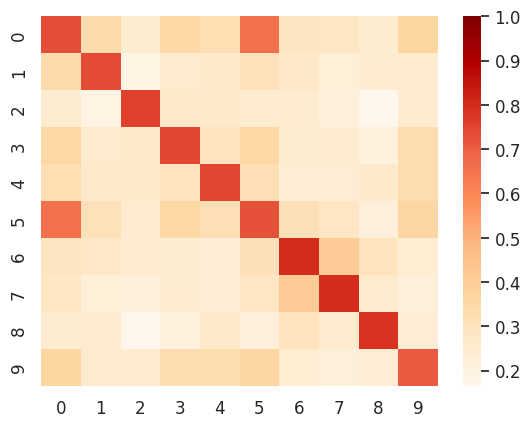

In [18]:
plot_similarity_heatmap(multimodal_embeddings_img[:batch_size], multimodal_embeddings_img[:batch_size])

### 3.2 [OPTIONAL] Store datset

In [19]:
# Store dataset
dataset.to_csv('dataset.csv', index = False)

## 4. Create a vector store - FAISS In memory vector store

Before creating the new vector search collection and index, we must first create three associated OpenSearch policies: encryption security policy, network security policy, and data access policy. 

### 4.1 Create a new FAISS vector Database

we will use the metat data to store the image location so we can read the image back from the vector db

In [20]:
from langchain.document_loaders import CSVLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.schema import Document



### 4.2 Setting up the In-Memory KNN search

In [21]:
metadata_dict =  [ {key:value} for i, (key, value) in enumerate(zip(dataset['item_name_in_en_us'].to_list(), dataset['img_full_path'].to_list()))] 

metadata_dict#['AmazonBasics Serene 16-Piece Old Fashioned and Coolers Glass Drinkware Set']

[{'AmazonBasics Serene 16-Piece Old Fashioned and Coolers Glass Drinkware Set': 's3://amazon-berkeley-objects/images/small/07/075e5d67.jpg'},
 {'[Find] Amazon Collection Platinum Plated Sterling Silver Clear Princess kattokyu-bikkuzirukoniasutaddopiasu Binaural Headset for Stud Earrings jee00087\xa0_ 120cl00qd00\xa0': 's3://amazon-berkeley-objects/images/small/c9/c923418f.jpg'},
 {'Arizona Desert Sand Horizon Photo with Wood Hanger': 's3://amazon-berkeley-objects/images/small/c6/c6889ed4.jpg'},
 {'AmazonBasics Adjustable Speaker Stand - 3.8 to 6-Foot, Steel': 's3://amazon-berkeley-objects/images/small/2b/2b90e918.jpg'},
 {"Amazon Brand - The Fix Women's Foley Tassel Slide Sandal, Taupe, 6.5 B US": 's3://amazon-berkeley-objects/images/small/2c/2c0416de.jpg'},
 {'AmazonBasics Eastlake Coolers Glass Drinkware Set, 15-Ounce, Set of 6': 's3://amazon-berkeley-objects/images/small/ea/ea0c6da6.jpg'},
 {'365 EVERYDAY VALUE Organic Light Cream, 1 PT': 's3://amazon-berkeley-objects/images/small/e

### 4.3 Ingest the image embeddings

Next you need to loop through your dataset and ingest items data into the cluster. A more robust and scalable solution for the embedding ingestion can be found in [Ingesting enriched data into Amazon ES](https://aws.amazon.com/blogs/industries/novartis-ag-uses-amazon-elasticsearch-k-nearest-neighbor-knn-and-amazon-sagemaker-to-power-search-and-recommendation/). The data ingestion for this POC should finish within 60 seconds. It also executes a simple query to verify the data have been ingested into the index.

In [22]:
#collection = aoss_client.create_collection(name=vector_store_name,type='VECTORSEARCH')
# create vector store
from langchain.document_loaders import CSVLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.schema import Document

from langchain.embeddings import BedrockEmbeddings
from langchain.vectorstores import FAISS

multimodal_embed_model = f'amazon.titan-embed-image-v1'
# create instantiation to embedding model
embedding_model = BedrockEmbeddings(
    client=boto3_bedrock,
    model_id=multimodal_embed_model
)

text_embedding_pairs = zip(dataset['item_name_in_en_us'].to_list(), multimodal_embeddings_img)
#metadata_dict =  dict ( [(key, value) for i, (key, value) in enumerate(zip(dataset['item_name_in_en_us'].to_list(), dataset['img_full_path'].to_list()))] )


db = FAISS.from_embeddings(text_embedding_pairs, embedding_model, metadatas=metadata_dict)

In [23]:
query_prompt = "drinkware glass"

v = embedding_model.embed_query(query_prompt)
print(v[0:10])
results = db.similarity_search_by_vector(v, k=2)
display(Markdown('Let us look at the documents which had the relevant information pertaining to our query'))
for r in results:
    display(Markdown(f'{r.page_content}'), Markdown(f'{r.metadata}'))
    display(Markdown(f'------------------------------------'))

[0.0055963546, -0.011778994, -0.027182294, 0.0016322702, -0.014070835, 0.023984378, 0.12109446, -0.022172224, -0.0056763026, -0.034111116]


Let us look at the documents which had the relevant information pertaining to our query

AmazonBasics Eastlake Coolers Glass Drinkware Set, 15-Ounce, Set of 6

{'AmazonBasics Eastlake Coolers Glass Drinkware Set, 15-Ounce, Set of 6': 's3://amazon-berkeley-objects/images/small/ea/ea0c6da6.jpg'}

------------------------------------

AmazonBasics Serene 16-Piece Old Fashioned and Coolers Glass Drinkware Set

{'AmazonBasics Serene 16-Piece Old Fashioned and Coolers Glass Drinkware Set': 's3://amazon-berkeley-objects/images/small/07/075e5d67.jpg'}

------------------------------------

In [24]:
print(results[0].metadata.values())
print(results[0].metadata.keys())

dict_values(['s3://amazon-berkeley-objects/images/small/ea/ea0c6da6.jpg'])
dict_keys(['AmazonBasics Eastlake Coolers Glass Drinkware Set, 15-Ounce, Set of 6'])


## 5. Perform a real-time Multimodal Search

Now that you have a working OpenSearch index to contain embeddings for your inventory, let's have a look at how you can generate embedding for new items. You'll use Amazon Titan Multimodal Embeddings G1 Generation 1 (G1) extracting text features and image features. 

Let’s take a look at the results of a simple query. After retrieving results from the OpenSearch service, we get the item names and images from dataset.

In [25]:
def get_image_from_faiss_results(results=None):
    image_list = []
    for img_path in iter(results[0].metadata.values()):
        print(img_path)

        if img_path.startswith('s3'):
            # download and store images locally 
            local_data_root = f'./data/images'
            local_file_name = img_path.split('/')[-1]
 
            s3down.download(img_path, local_data_root)
 
            local_image_path = f"{local_data_root}/{local_file_name}"
    
        img = Image.open(local_image_path)
        image_list.append(img)

    return image_list

### 5.1. Perform Image Search based on Text Input

Let’s take a look at the results of a simple query. In below example, we'll receive an text input i.e. "drinkware glass" from user, and then will send it to search engine to find the similar items.

Find the similar items based on use queries. You can see that we found glass drinkware from our dataset based on the input query. That's what we want to achieve.

s3://amazon-berkeley-objects/images/small/ea/ea0c6da6.jpg


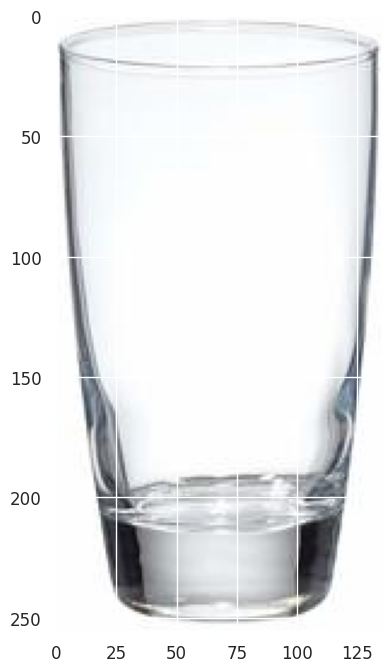

In [26]:
query_prompt = "drinkware glass"
v = embedding_model.embed_query(query_prompt)
results = db.similarity_search_by_vector(v, k=2)

all_images = get_image_from_faiss_results(results)

display_images(all_images)



### 5.2 Perform Image Search based on Image Input

Let’s take a look at the results based on a simple image. The input image will get coverted into vector embeddings and based on the similarity search, it will return the result,

You can use any image, but for below example, we'll select a random image from the above dataset based on item_id (for ex. item_id = "B07JCDQWM6" ),  and then will send this image to search engine to find the similar items. First, Let's get the image amd image location based on the item id.

AmazonBasics Serene 16-Piece Old Fashioned and Coolers Glass Drinkware Set


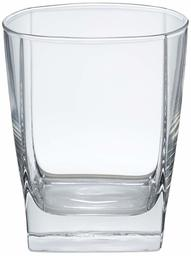

In [27]:
item_id = "B0896LJNLH"

image, item_name = get_image_from_item_id_s3(item_id = item_id, dataset = dataset, image_path = f's3://amazon-berkeley-objects/images/small/' )
print(item_name)
image

Then, get the similar items based on the image above

In [28]:
""" 
Function for semantic search capability using knn on input image prompt.
"""
def find_similar_items_from_image(image_path: str, k_nn: int ) -> []:
    """
    Main semantic search capability using knn on input image prompt.
    Args:
        k: number of top-k similar vectors to retrieve from OpenSearch index
        num_results: number of the top-k similar vectors to retrieve
        index_name: index name in OpenSearch
    """
    query_emb = get_titan_multimodal_embedding_fix(image_path=search_image_path, dimension=1024)["embedding"]
    #print(query_emb)
    results = db.similarity_search_by_vector(query_emb, k=2)
    print(results)
    image_list = get_image_from_faiss_results(results)
    return image_list


s3://amazon-berkeley-objects/images/small/07/075e5d67.jpg
 get_titan_multimodal_embedding_fix()::payload:keys=dict_keys(['inputImage'])::
[Document(page_content='AmazonBasics Serene 16-Piece Old Fashioned and Coolers Glass Drinkware Set', metadata={'AmazonBasics Serene 16-Piece Old Fashioned and Coolers Glass Drinkware Set': 's3://amazon-berkeley-objects/images/small/07/075e5d67.jpg'}), Document(page_content='AmazonBasics Eastlake Coolers Glass Drinkware Set, 15-Ounce, Set of 6', metadata={'AmazonBasics Eastlake Coolers Glass Drinkware Set, 15-Ounce, Set of 6': 's3://amazon-berkeley-objects/images/small/ea/ea0c6da6.jpg'})]
s3://amazon-berkeley-objects/images/small/07/075e5d67.jpg


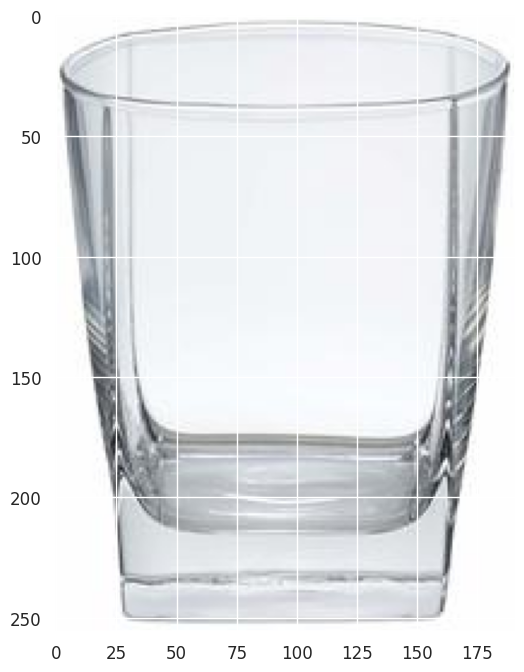

In [29]:
item_id = "B0896LJNLH"
search_image_path = dataset[dataset['item_id']==item_id]['img_full_path'].iloc[0]
print(search_image_path)

image_list = find_similar_items_from_image(search_image_path, 2)
display_images(image_list)

## Query an Image - Multimodal model Claude sonnet

 Now let us send in a query based on an image. The image is a generic flights dashboard

In [34]:
from PIL import Image

with open("./images/departure_rate.jpg", "rb") as image_file:
    content_image = base64.b64encode(image_file.read()).decode('utf8')

In [35]:
type(content_image)

str

In [36]:
import json 
import boto3
import os
from IPython.display import Markdown, display



region = os.environ.get("AWS_REGION")
bedrock = boto3.client(
    service_name='bedrock-runtime',
    region_name=region,
)

with open("./images/departure_rate.jpg", "rb") as image_file:
    content_image = base64.b64encode(image_file.read()).decode('utf8')

body=json.dumps(
        {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": 100,
            "messages": [{
                "role": "user",
                "content": [{
                  "type": "image",
                  "source": {
                    "type": "base64",
                    "media_type": "image/jpeg",
                    "data": content_image,
                  }
                },
                {
                  "type": "text",
                  "text": "Give me the flight timings from here."
                }
                ]
            }],
            "temperature": 0.5,
            "top_p": 0.9
        }  
    )  
modelId = "anthropic.claude-3-sonnet-20240229-v1:0"
accept = "application/json"
contentType = "application/json"

response = bedrock.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())
response_body



{'id': 'msg_bdrk_01ABn4QFTauQXKN4LdqbcbX8',
 'type': 'message',
 'role': 'assistant',
 'model': 'claude-3-sonnet-20240229',
 'content': [{'type': 'text',
   'text': 'According to the departures board shown in the image, here are the flight timings listed:\n\n18:03 - Current time displayed\n18:08 - Flight to New York (AC 103)\n18:16 - Flight to Berlin (CI5723)\n18:38 - Flight to London (MU5984)\n18:49 - Flight to Tokyo (JL 608)\n19:07 - Flight to Hong Kong (CX'}],
 'stop_reason': 'max_tokens',
 'stop_sequence': None,
 'usage': {'input_tokens': 776, 'output_tokens': 100}}

## 6. Clean up

When you finish this exercise, remove your resources with the following steps:

Delete vector index.
Delete data, network, and encryption access ploicies.
Delete collection.
Delete SageMaker Studio user profile and domain.
Optionally, empty and delete the S3 bucket, or keep whatever you want.  

In [ ]:
# - since these are in memory nothing to delete